In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d aumashe/stock-ew
!unzip stock-ew.zip

  0% 0.00/69.3k [00:00<?, ?B/s]
100% 69.3k/69.3k [00:00<00:00, 22.2MB/s]
Archive:  stock-ew.zip
  inflating: EW-MAX.csv              


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib as mpl

tf.random.set_seed(11)
np.random.seed(11)

In [ ]:
dataframe=pd.read_csv("/content/EW-MAX.csv")

In [ ]:
dataframe.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


In [ ]:
dataframe.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000,4.392000e+03
mean,30.562539,30.893618,30.238833,30.572580,30.572580,1.884027e+06
std,29.914758,30.210974,29.615761,29.905778,29.905778,1.621609e+06
min,3.296875,3.390625,3.000000,3.250000,3.250000,1.904000e+05
25%,8.718125,8.803125,8.625000,8.712500,8.712500,1.088800e+06
50%,14.766250,14.981250,14.662500,14.767500,14.767500,1.539300e+06
75%,42.546248,43.051249,42.086249,42.539999,42.539999,2.188900e+06
max,121.080002,121.750000,120.169998,121.360001,121.360001,4.641260e+07


In [ ]:
dataframe.shape

(4392, 7)

In [ ]:
dataframe.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj_Close    0
Volume       0
dtype: int64

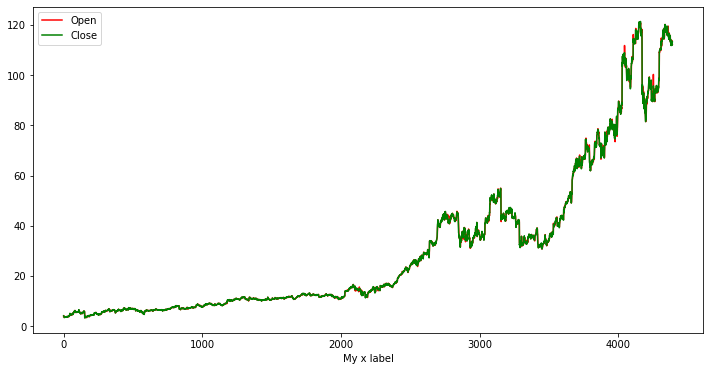

In [ ]:
plt.rcParams["figure.figsize"] = (12,6)
ax1 = dataframe.plot(y='Open',color='red', markersize=21)
ax2 = dataframe.plot(y='Close', ax=ax1,color='green', markersize=5)
plt.xlabel('My x label') # set a label for the x-axis
plt.show()


For this project we will only look at 2 fields 


*   Open
*   Close




In [ ]:
data=dataframe[['Date','Close']]

Using only last 1 year data

In [ ]:
new_df = data.loc[4000:]
new_df.head()


,Date,Close
4000,2016/2/22,86.610001
4001,2016/2/23,86.870003
4002,2016/2/24,87.790001
4003,2016/2/25,89.559998
4004,2016/2/26,87.930000


In [ ]:
##new_df is a tempory variable that we contains original dataset without 'Date'
new_df=new_df.drop("Date",axis=1)
new_df=new_df.reset_index(drop=True) 


T = new_df.astype('float32')
T = np.reshape(T,(-1,1))
T

,Close
0,86.610001
1,86.870003
2,87.790001
3,89.559998
4,87.930000
...,...
387,113.309998
388,111.870003
389,112.230003
390,112.339996


In [ ]:
##This is to make sure the vaues stay in range of 0-1 only. 
scaler=MinMaxScaler(feature_range=(0,1))
T=scaler.fit_transform(T)

In [ ]:
# 80-20 split
train_size = int(len(T) * 0.80)
test_size = int(len(T) - train_size)
train, test = T[0:train_size,:], T[train_size:len(T),:]

In [ ]:
def create_features(data, window_size):
    X, Y = [], []
    for i in range(len(data) - window_size - 1):
        window = data[i:(i + window_size), 0]
        X.append(window)
        Y.append(data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [ ]:
window_size = 20
X_train, Y_train = create_features(train, window_size)

X_test, Y_test = create_features(test, window_size)

# Reshape to the format of [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

T_shape = T.shape
train_shape = train.shape
test_shape = test.shape

In [ ]:
def isLeak(T_shape,train_shape,test_shape):
  return not (T_shape[0]==(train_shape[0]+test_shape[0]))

In [ ]:
##To make sure all have the same dimensions
print(isLeak(T_shape,train_shape,test_shape))


False


# Building the Model

In [ ]:
model = Sequential()

model.add(LSTM(units = 50, activation = 'relu', return_sequences = False, 
               input_shape = (X_train.shape[1], window_size)))
model.add(Dropout(0.2))
# Output layer
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')


In [ ]:
# Save models
filepath = 'saved_models/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, Y_train, epochs = 100, batch_size = 25, validation_data = (X_test, Y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, shuffle = False)

Epoch 1/100
 1/12 [=>............................] - ETA: 31s - loss: 0.3395
Epoch 1: val_loss improved from inf to 0.59439, saving model to saved_models/model_epoch_01.hdf5
12/12 [==============================] - 3s 34ms/step - loss: 0.3714 - val_loss: 0.5944
Epoch 2/100
 1/12 [=>............................] - ETA: 0s - loss: 0.2435
Epoch 2: val_loss improved from 0.59439 to 0.27824, saving model to saved_models/model_epoch_02.hdf5
12/12 [==============================] - 0s 8ms/step - loss: 0.2099 - val_loss: 0.2782
Epoch 3/100
 1/12 [=>............................] - ETA: 0s - loss: 0.1620
Epoch 3: val_loss improved from 0.27824 to 0.07454, saving model to saved_models/model_epoch_03.hdf5
12/12 [==============================] - 0s 7ms/step - loss: 0.1032 - val_loss: 0.0745
Epoch 4/100
 1/12 [=>............................] - ETA: 0s - loss: 0.1051
Epoch 4: val_loss improved from 0.07454 to 0.00312, saving model to saved_models/model_epoch_04.hdf5
12/12 [==========================

In [ ]:
best_model = load_model('/content/saved_models/model_epoch_23.hdf5')

In [ ]:
train_predict = best_model.predict(X_train)
Y_hat_train = scaler.inverse_transform(train_predict)

test_predict = best_model.predict(X_test)
Y_hat_test = scaler.inverse_transform(test_predict)

In [ ]:
# Inverse transforming the actual values, to return them to their original values
Y_test = scaler.inverse_transform([Y_test])
Y_train = scaler.inverse_transform([Y_train])

In [ ]:
X_train.shape[0]

292

In [ ]:
# Reshaping 
Y_hat_train = np.reshape(Y_hat_train, newshape = Y_train.shape[1])
Y_hat_test = np.reshape(Y_hat_test, newshape = Y_test.shape[1] )

Y_train = np.reshape(Y_train, newshape = Y_train.shape[1])
Y_test = np.reshape(Y_test, newshape = Y_test.shape[1])

In [ ]:
### Model performance evaluation


train_RMSE = np.sqrt(mean_squared_error(Y_train, Y_hat_train))

test_RMSE = np.sqrt(mean_squared_error(Y_test, Y_hat_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
3.5484735791470934 

Test RMSE is: 
1.2112872515309898
